# 1- IMPORT LIBRARIES

In [73]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 2- IMPORTING DATA FROM CSV

In [5]:
df = pd.read_csv(
  "C:\\Users\\MO\\Desktop\\london_merged.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [6]:
df.shape

(17414, 9)

In [7]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [8]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# 3- PLOTTING VIA SEABORN

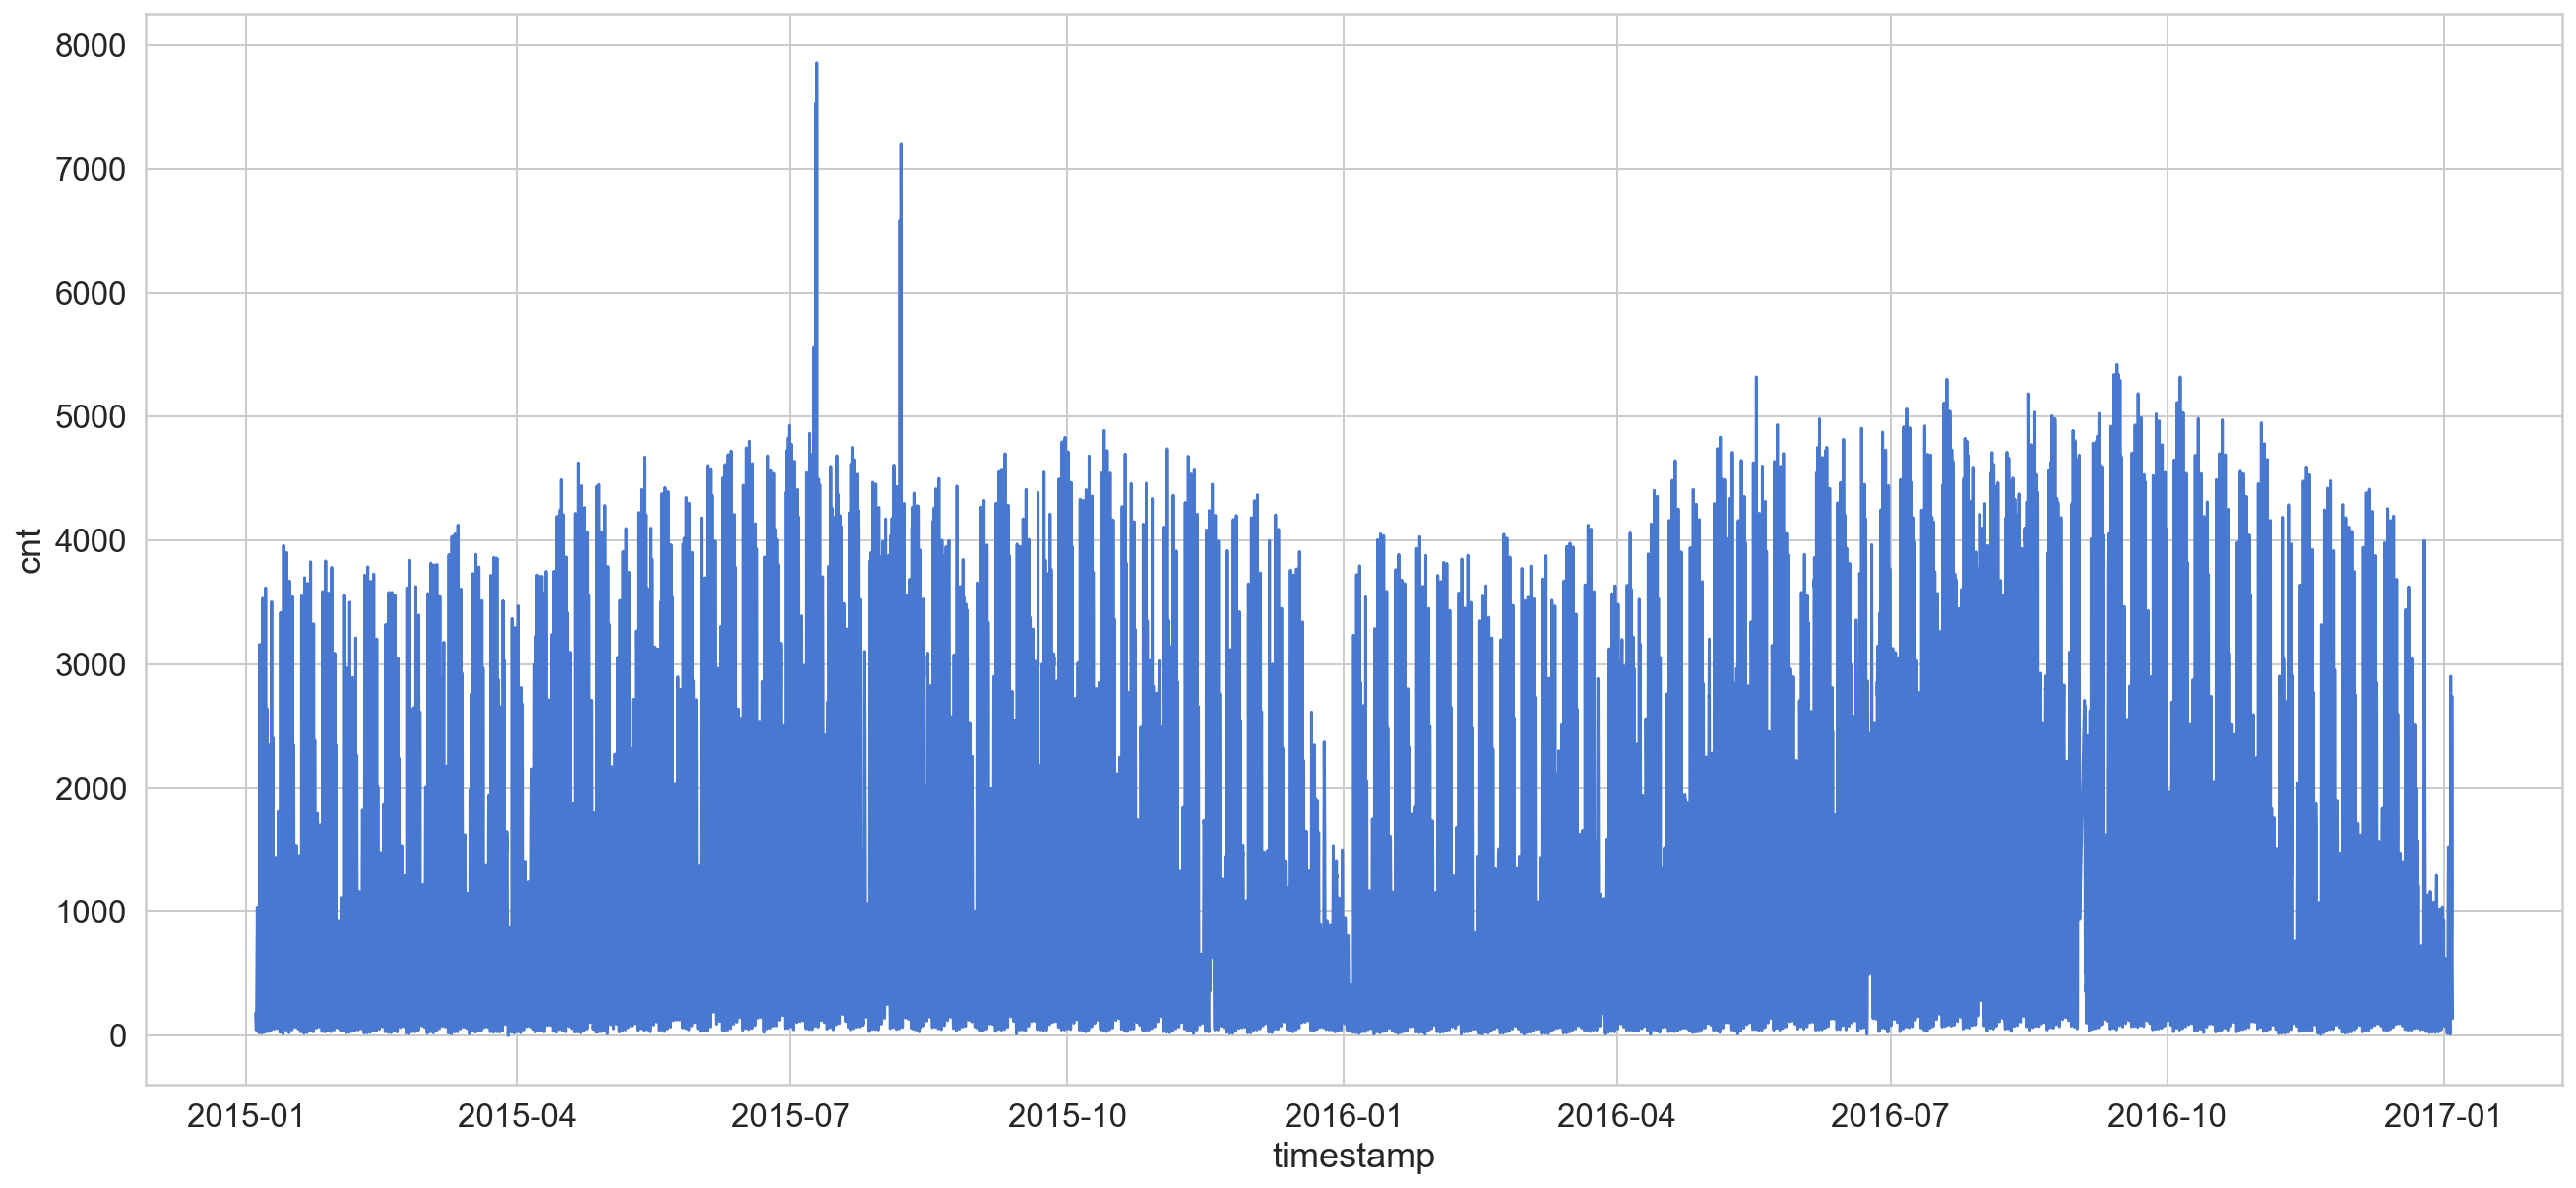

In [9]:
sns.lineplot(x=df.index, y="cnt", data=df);

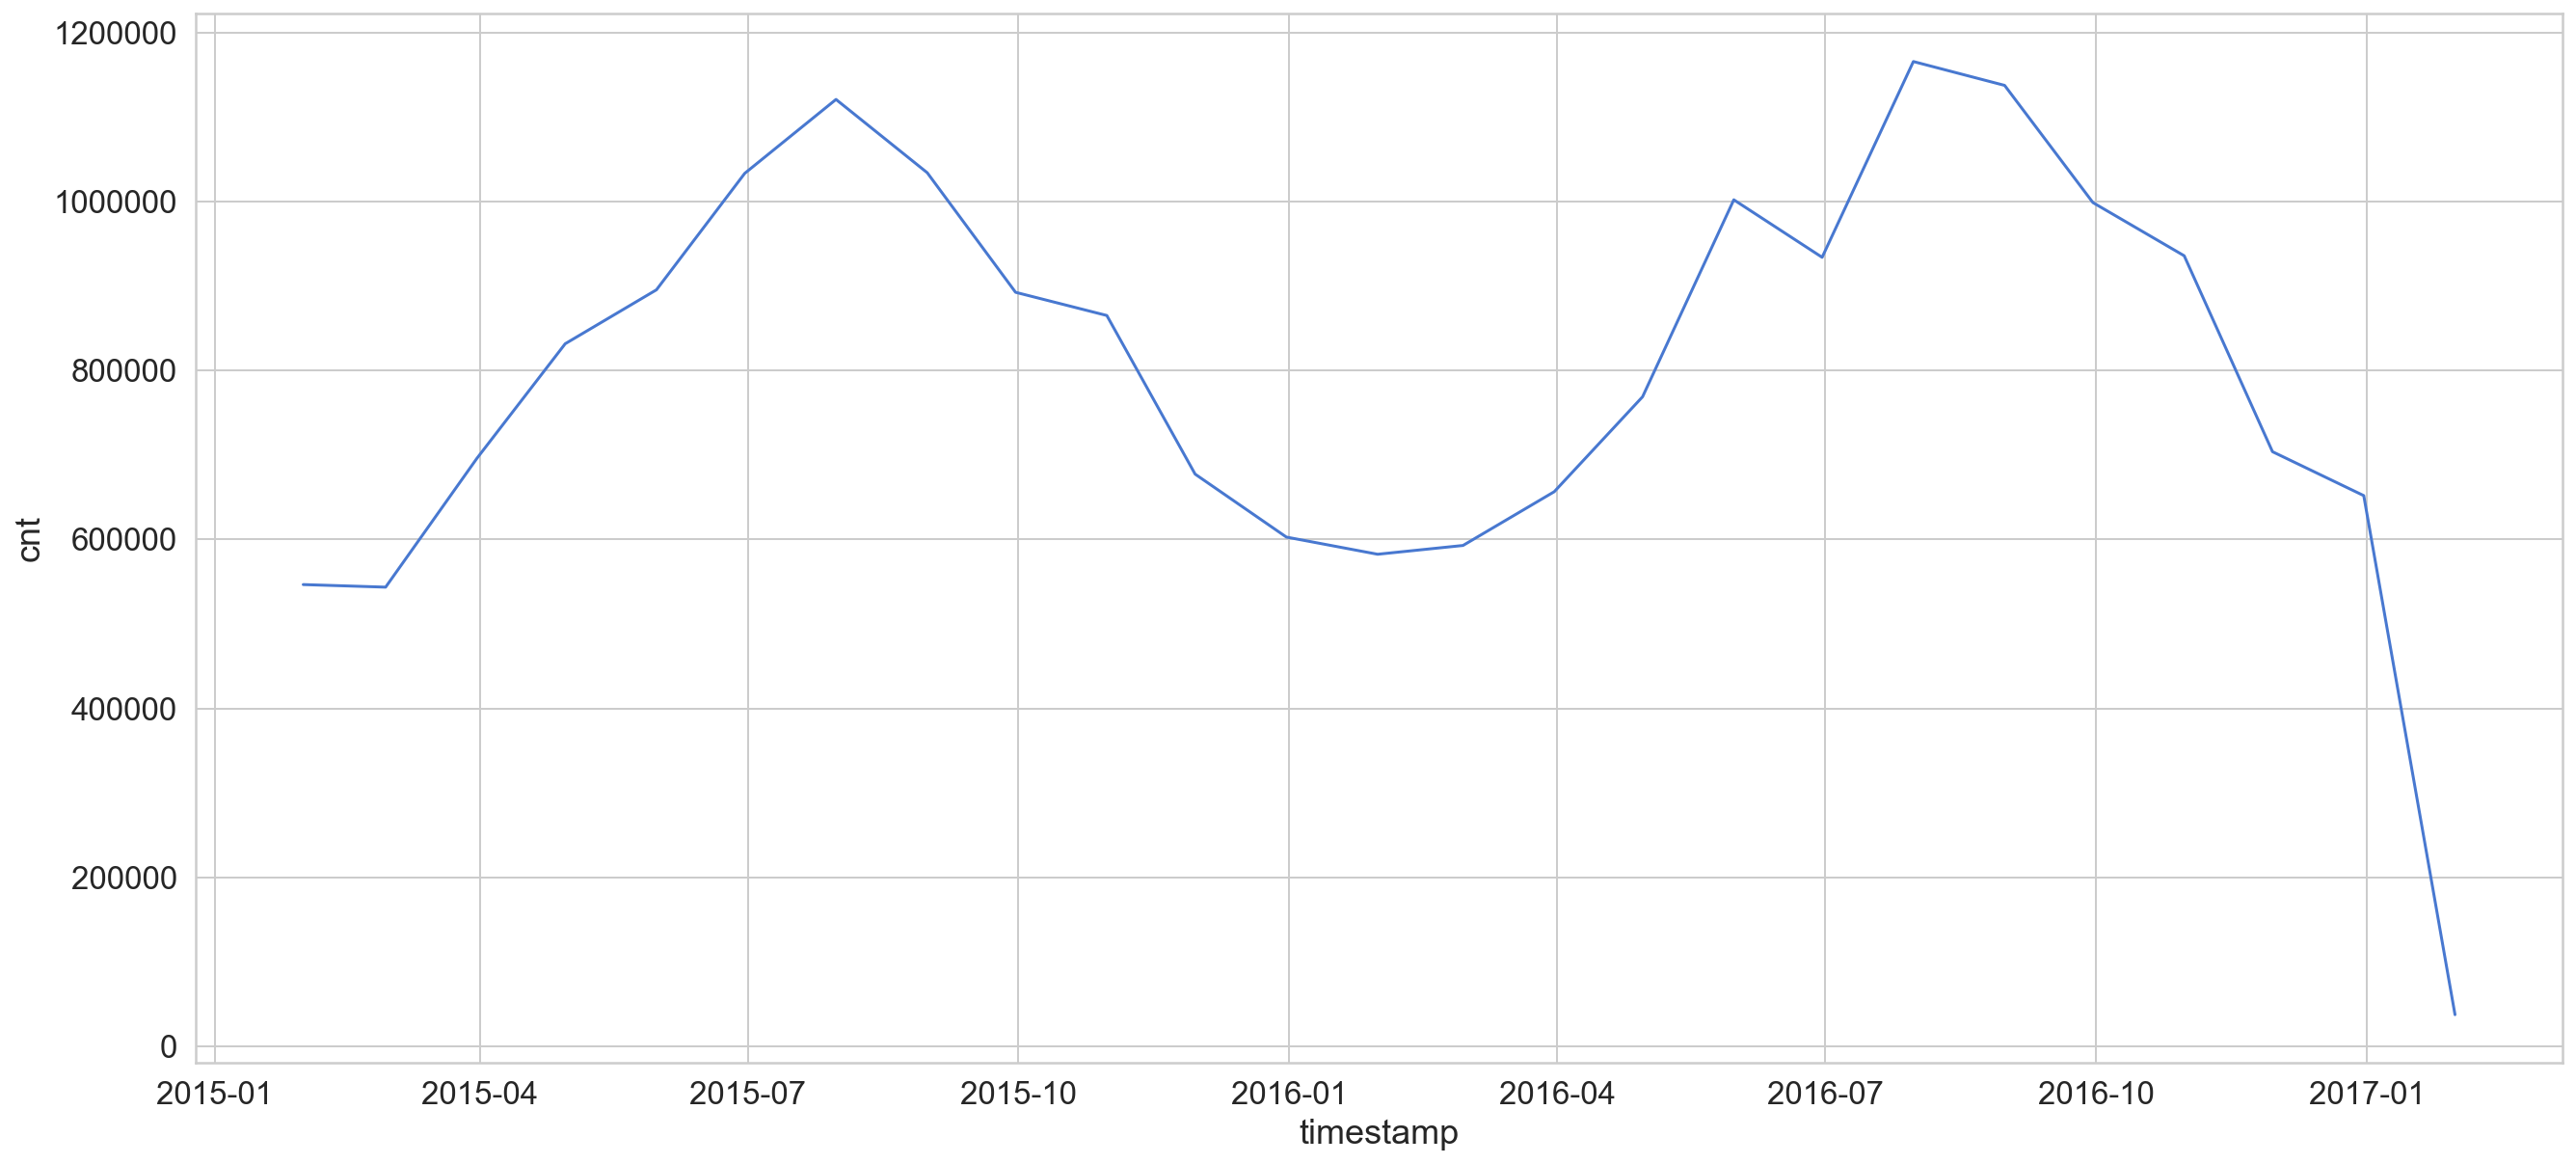

In [10]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

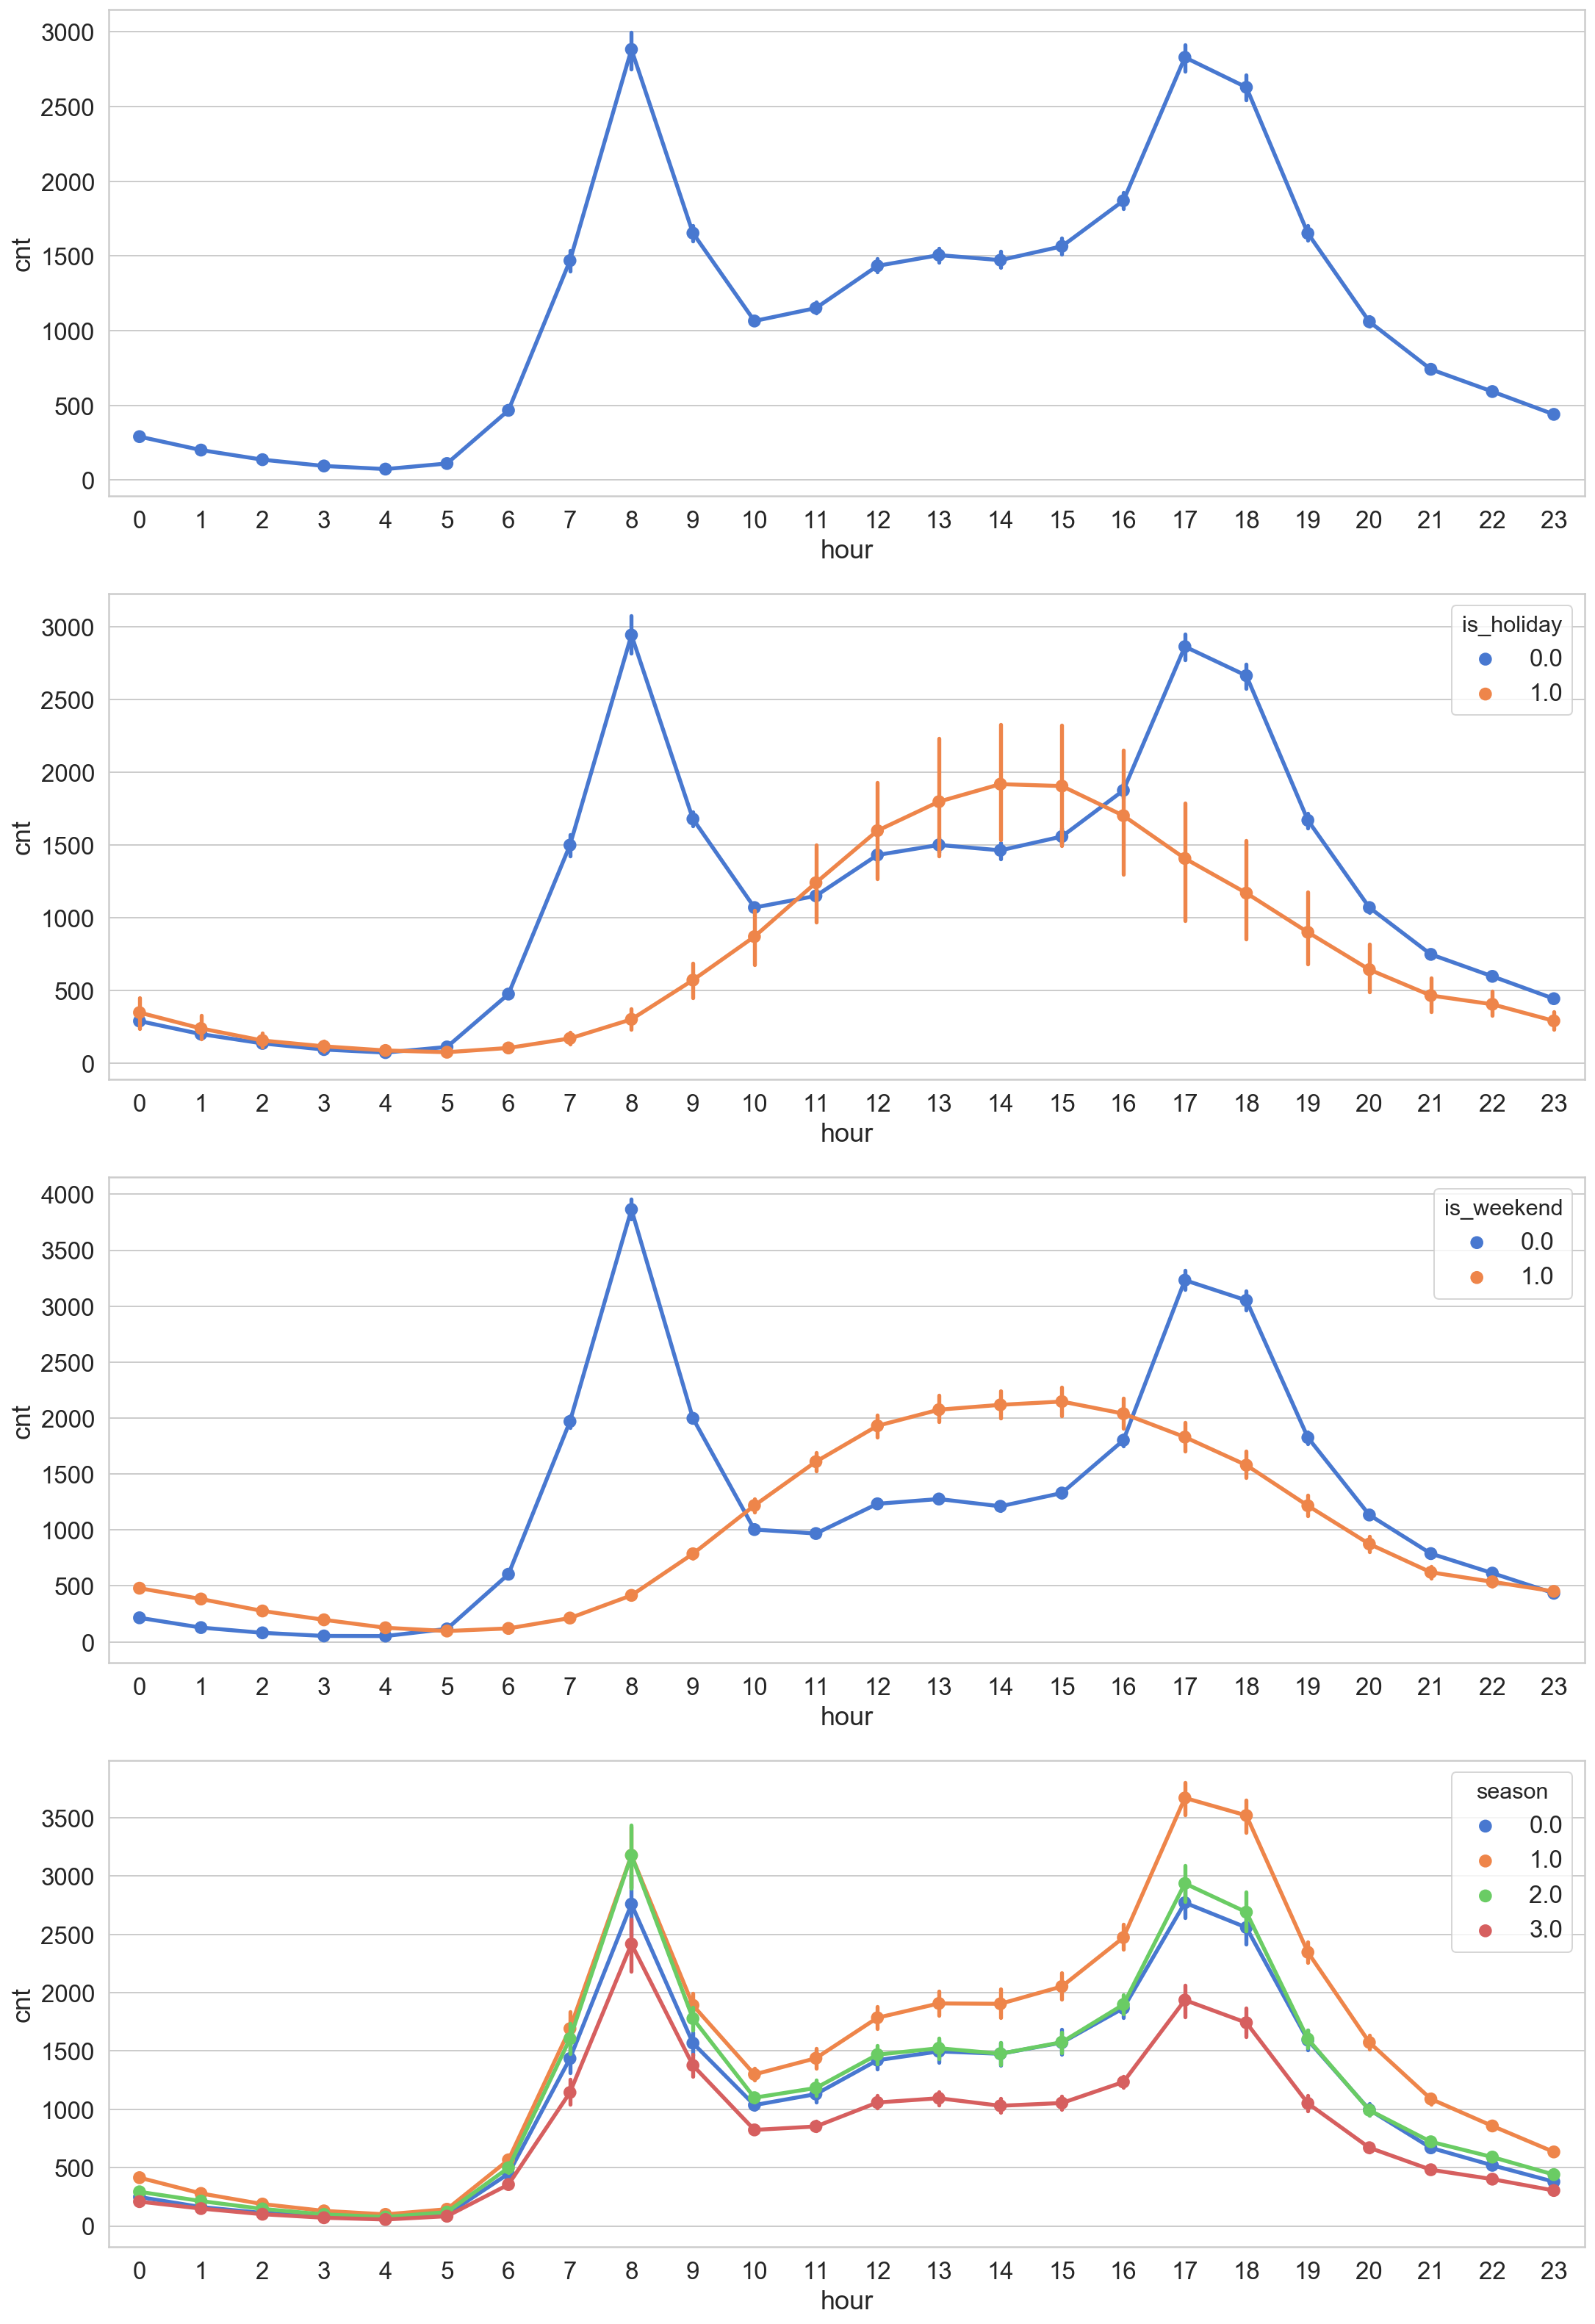

In [11]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

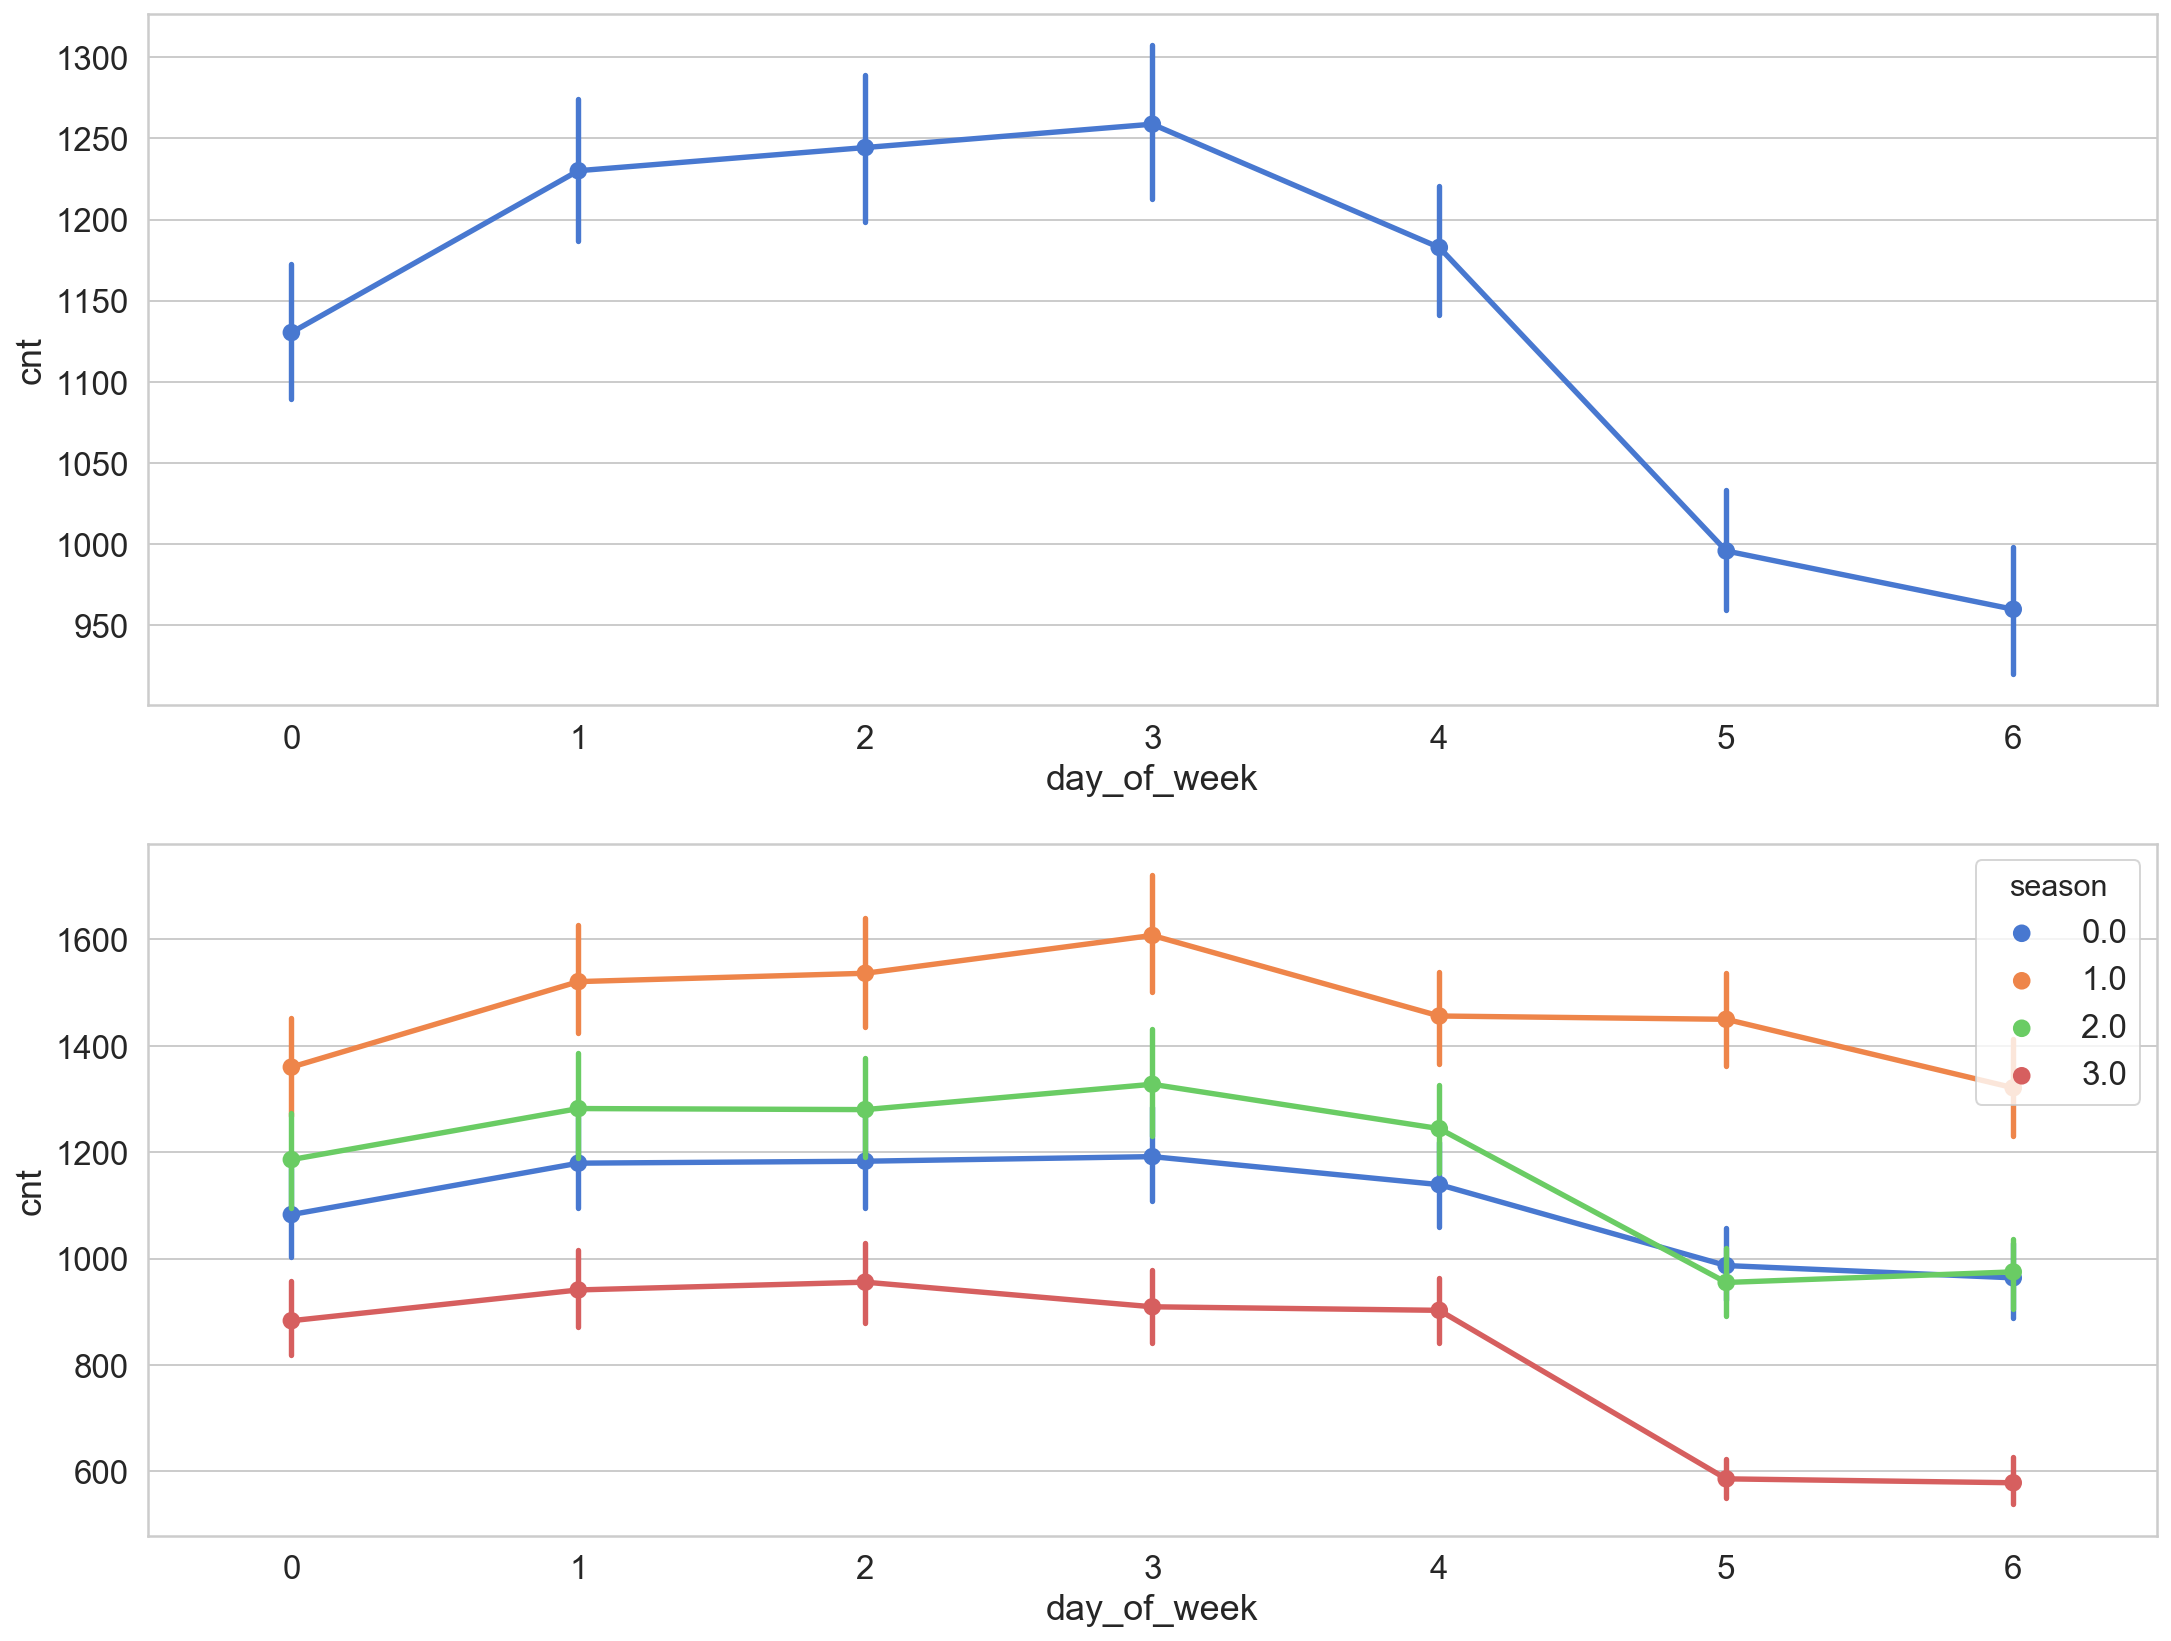

In [12]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

# 4-SPLIT THE DATA

In [13]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


# 5-Preprocessing

In [14]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

C:\Users\MO\AppData\Local\Continuum\anaconda3\envs\tensorenviron\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\MO\AppData\Local\Continuum\anaconda3\envs\tensorenviron\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\MO\AppData\Local\Continuum\anaconda3\envs\tensorenviron\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be

In [15]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [16]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


# 6- BUILD THE PREDICTION MODEL(ARCH-COMPILE-FIT)

In [17]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Train on 14095 samples, validate on 1567 samples
Epoch 1/30
14095/14095 [==============================] - 13s 927us/sample - loss: 0.3126 - val_loss: 0.1138
Epoch 2/30
14095/14095 [==============================] - 6s 424us/sample - loss: 0.0832 - val_loss: 0.0526
Epoch 3/30
14095/14095 [==============================] - 6s 416us/sample - loss: 0.0506 - val_loss: 0.0494
Epoch 4/30
14095/14095 [==============================] - 6s 422us/sample - loss: 0.0384 - val_loss: 0.0389
Epoch 5/30
14095/14095 [==============================] - 6s 416us/sample - loss: 0.0318 - val_loss: 0.0319
Epoch 6/30
14095/14095 [==============================] - 6s 409us/sample - loss: 0.0290 - val_loss: 0.0322
Epoch 7/30
14095/14095 [==============================] - 6s 419us/sample - loss: 0.0260 - val_loss: 0.0368
Epoch 8/30
14095/14095 [==============================] - 6s 401us/sample - loss: 0.0239 - val_loss: 0.0373
Epoch 9/30
14095/14095 [==============================] - 6s 415us/sample - loss: 0.02

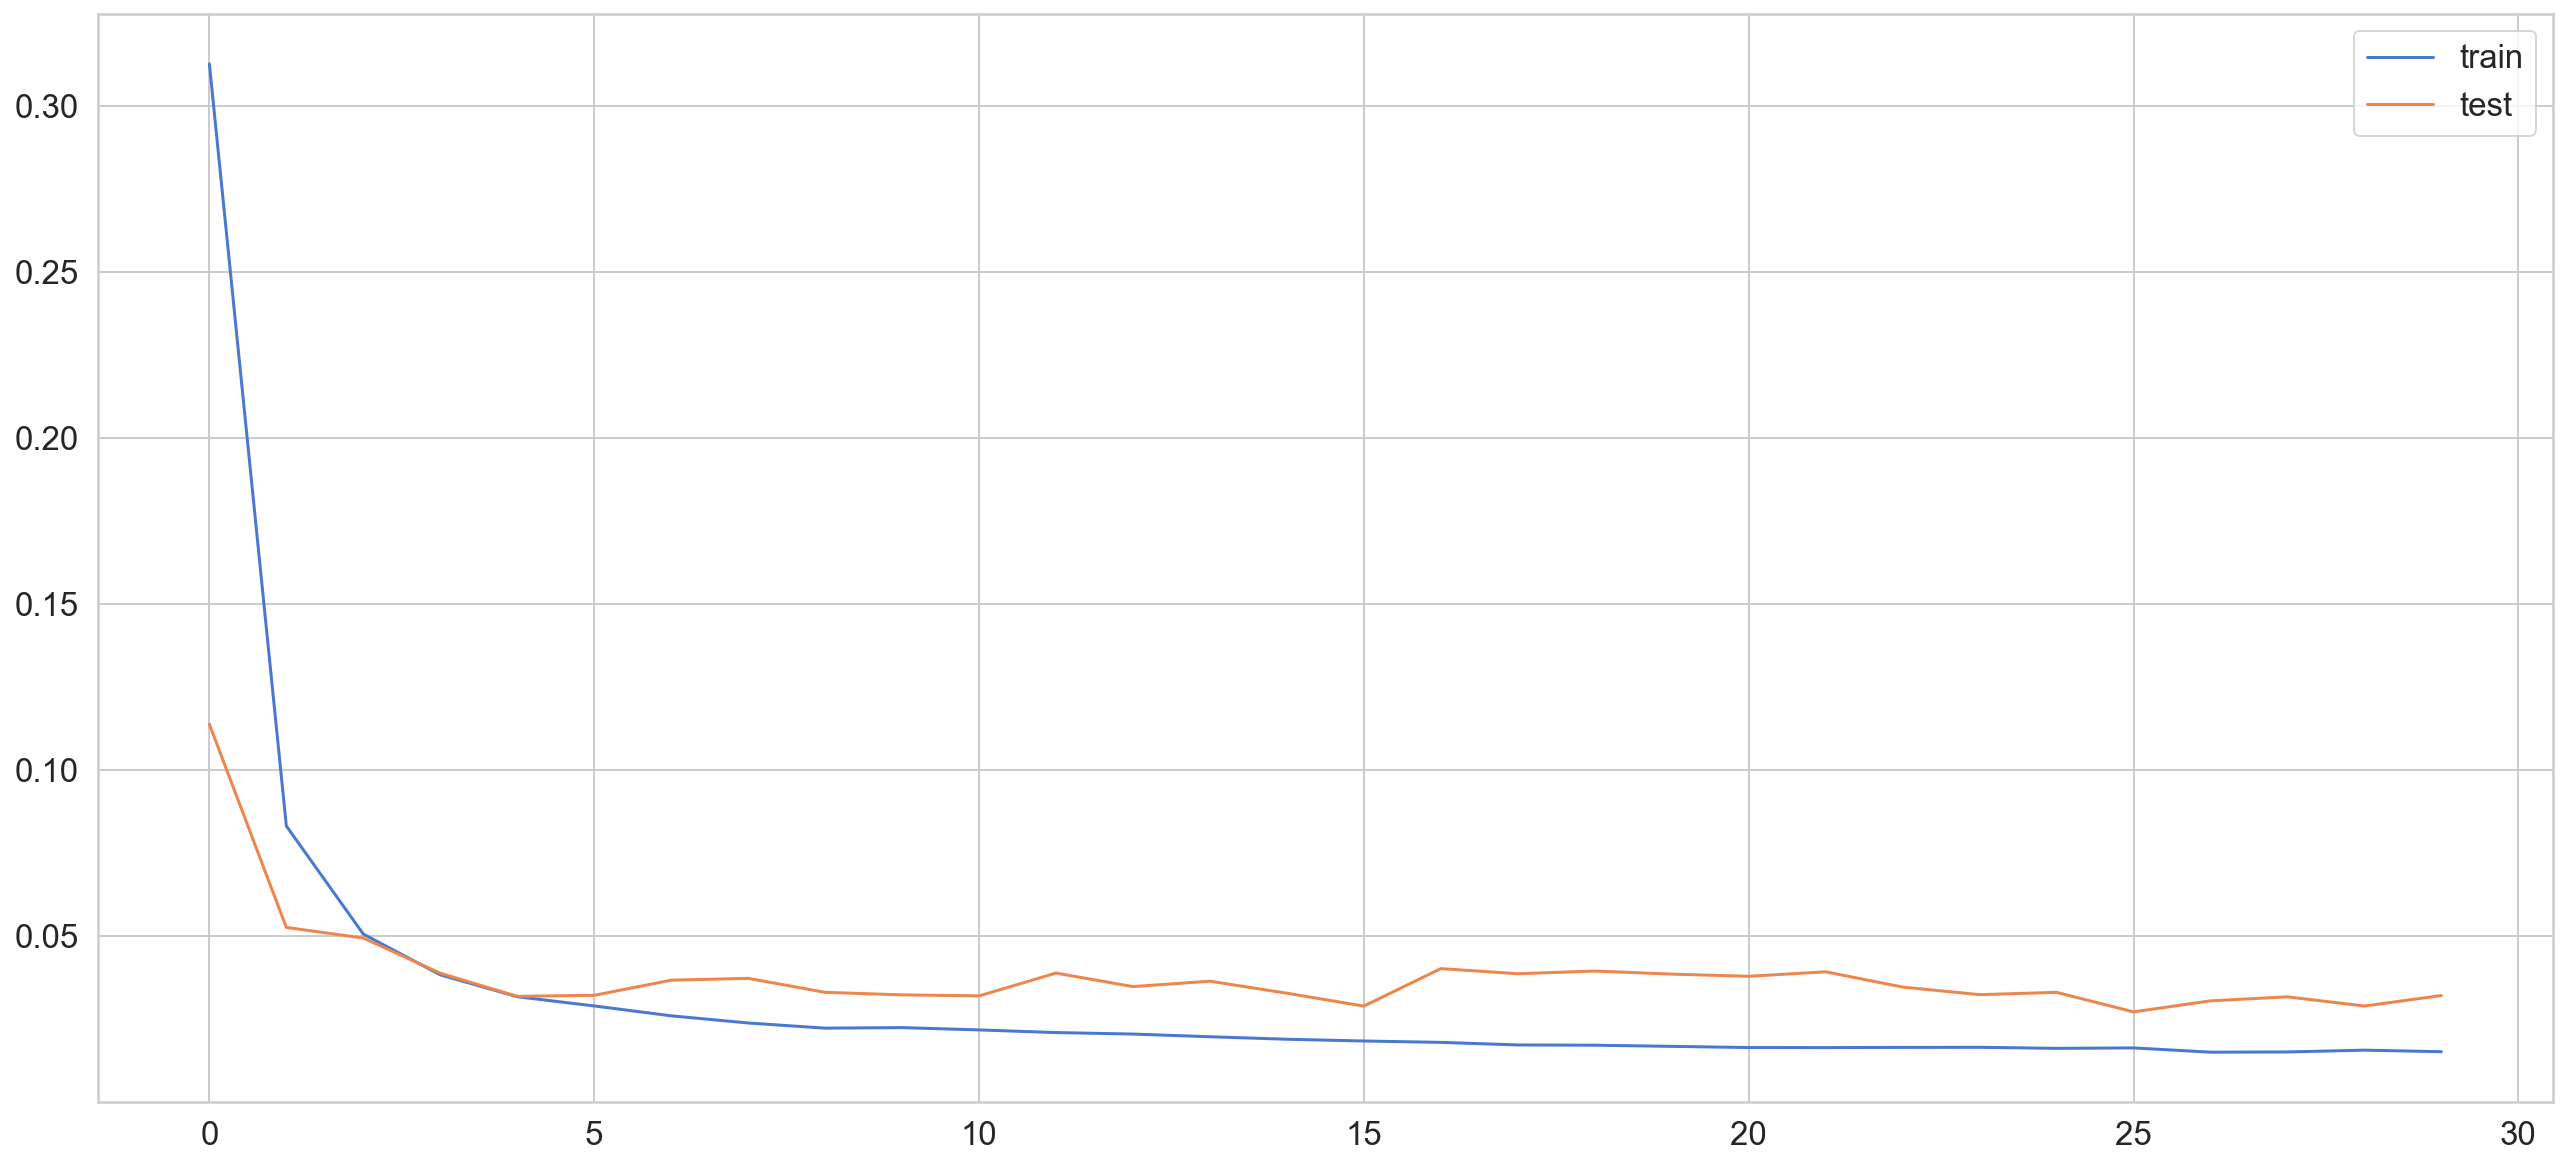

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [25]:
y_pred = model.predict(X_test)

In [26]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

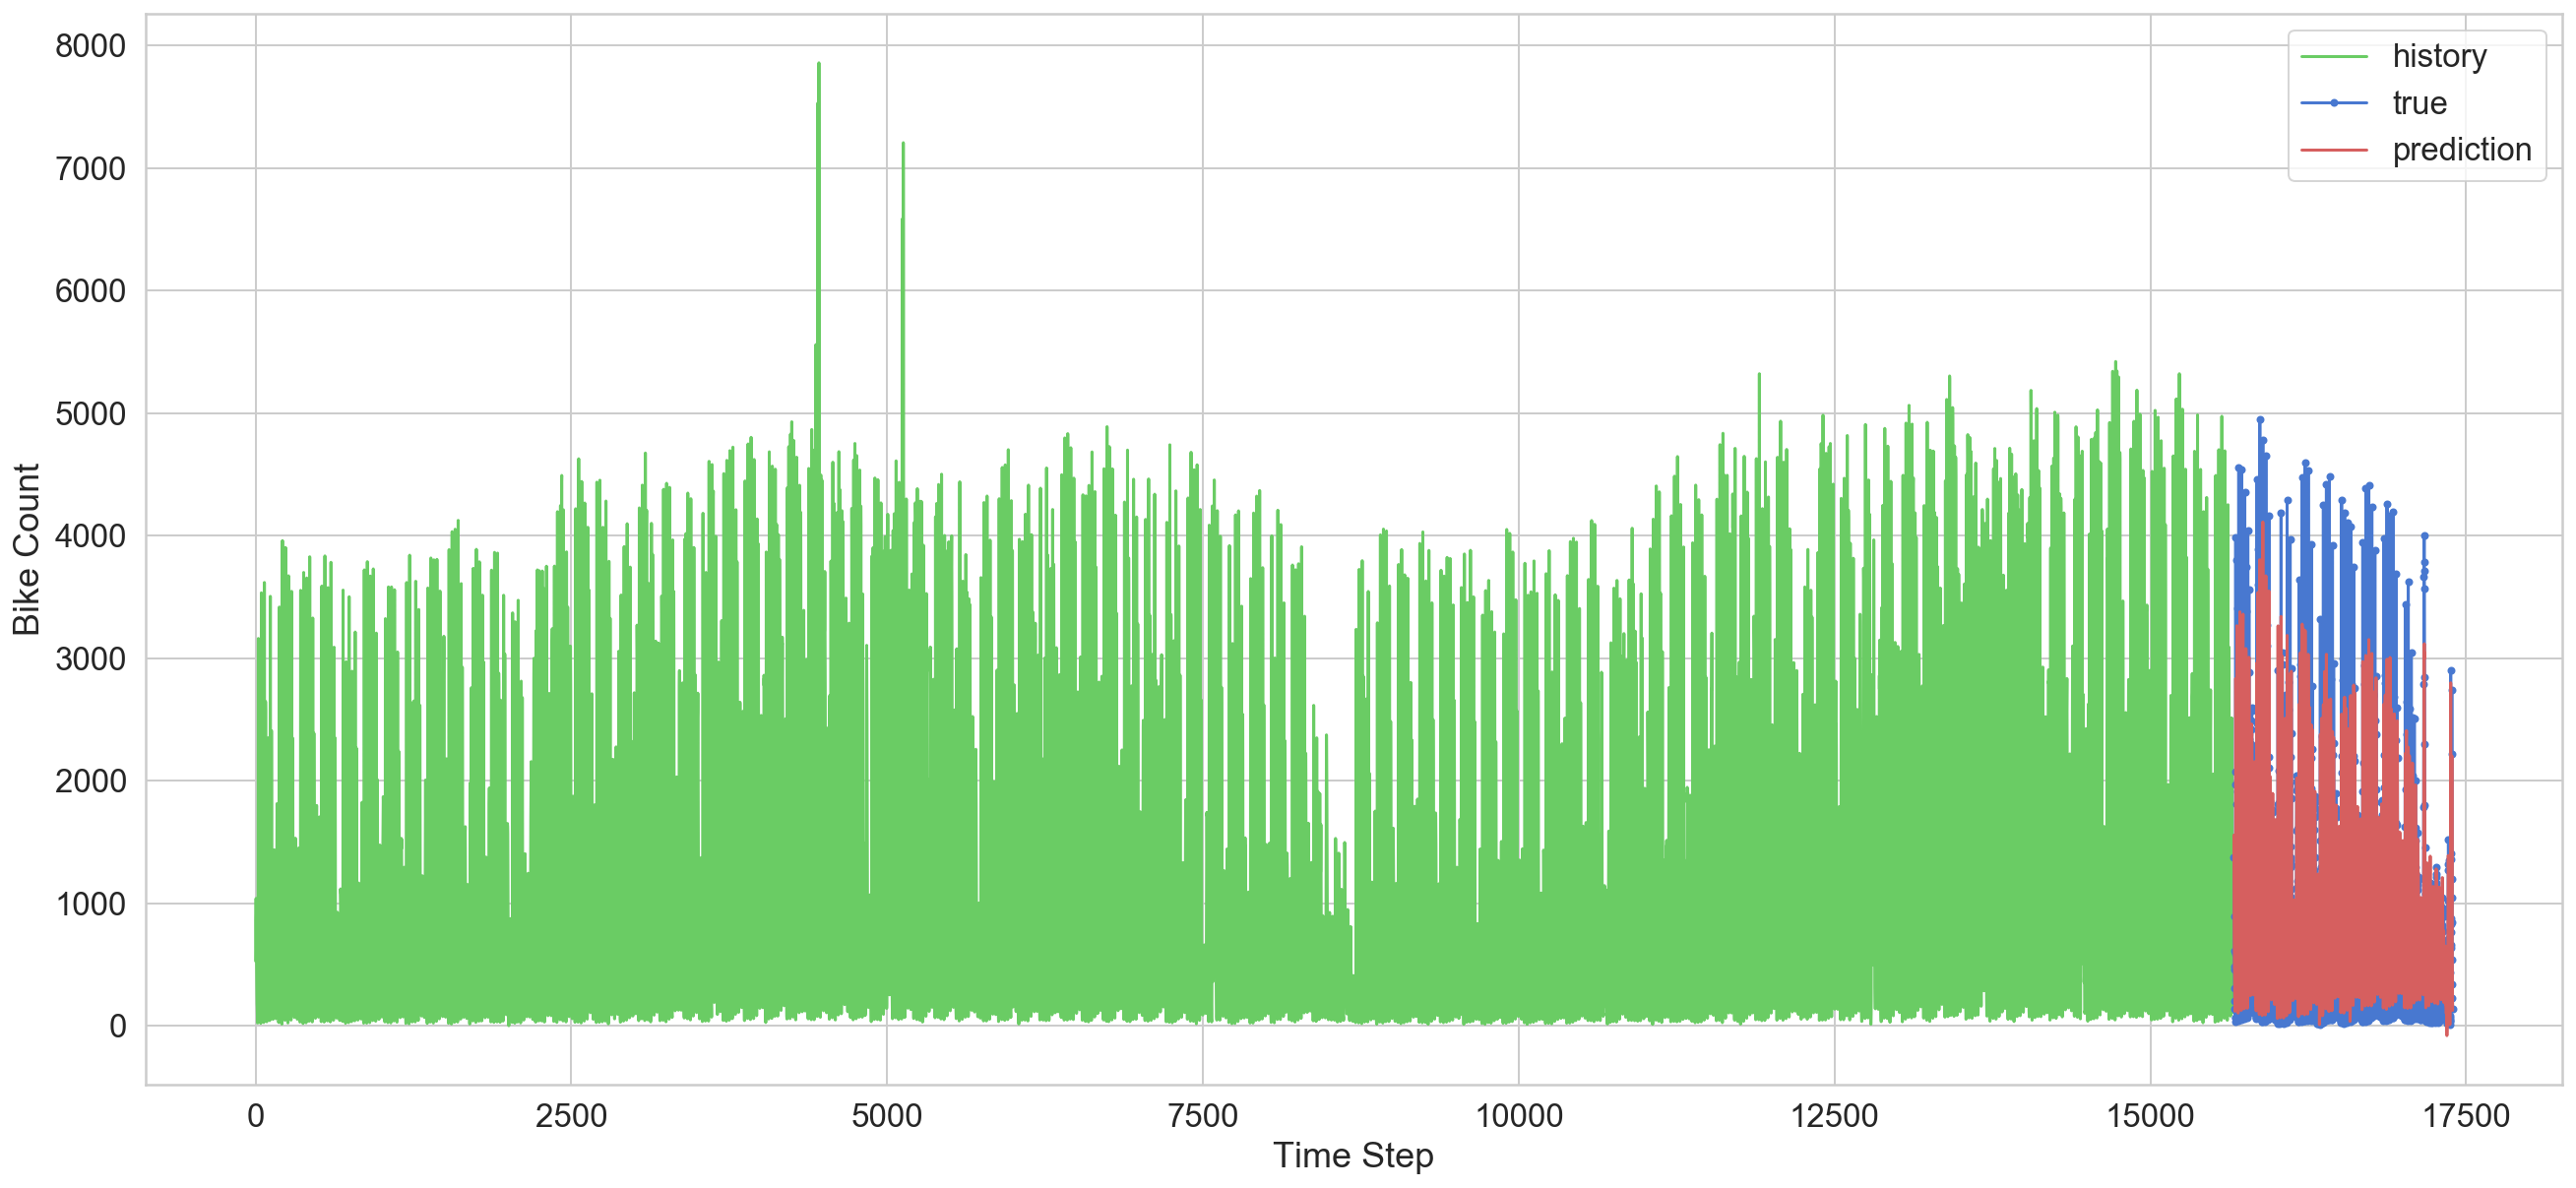

In [27]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

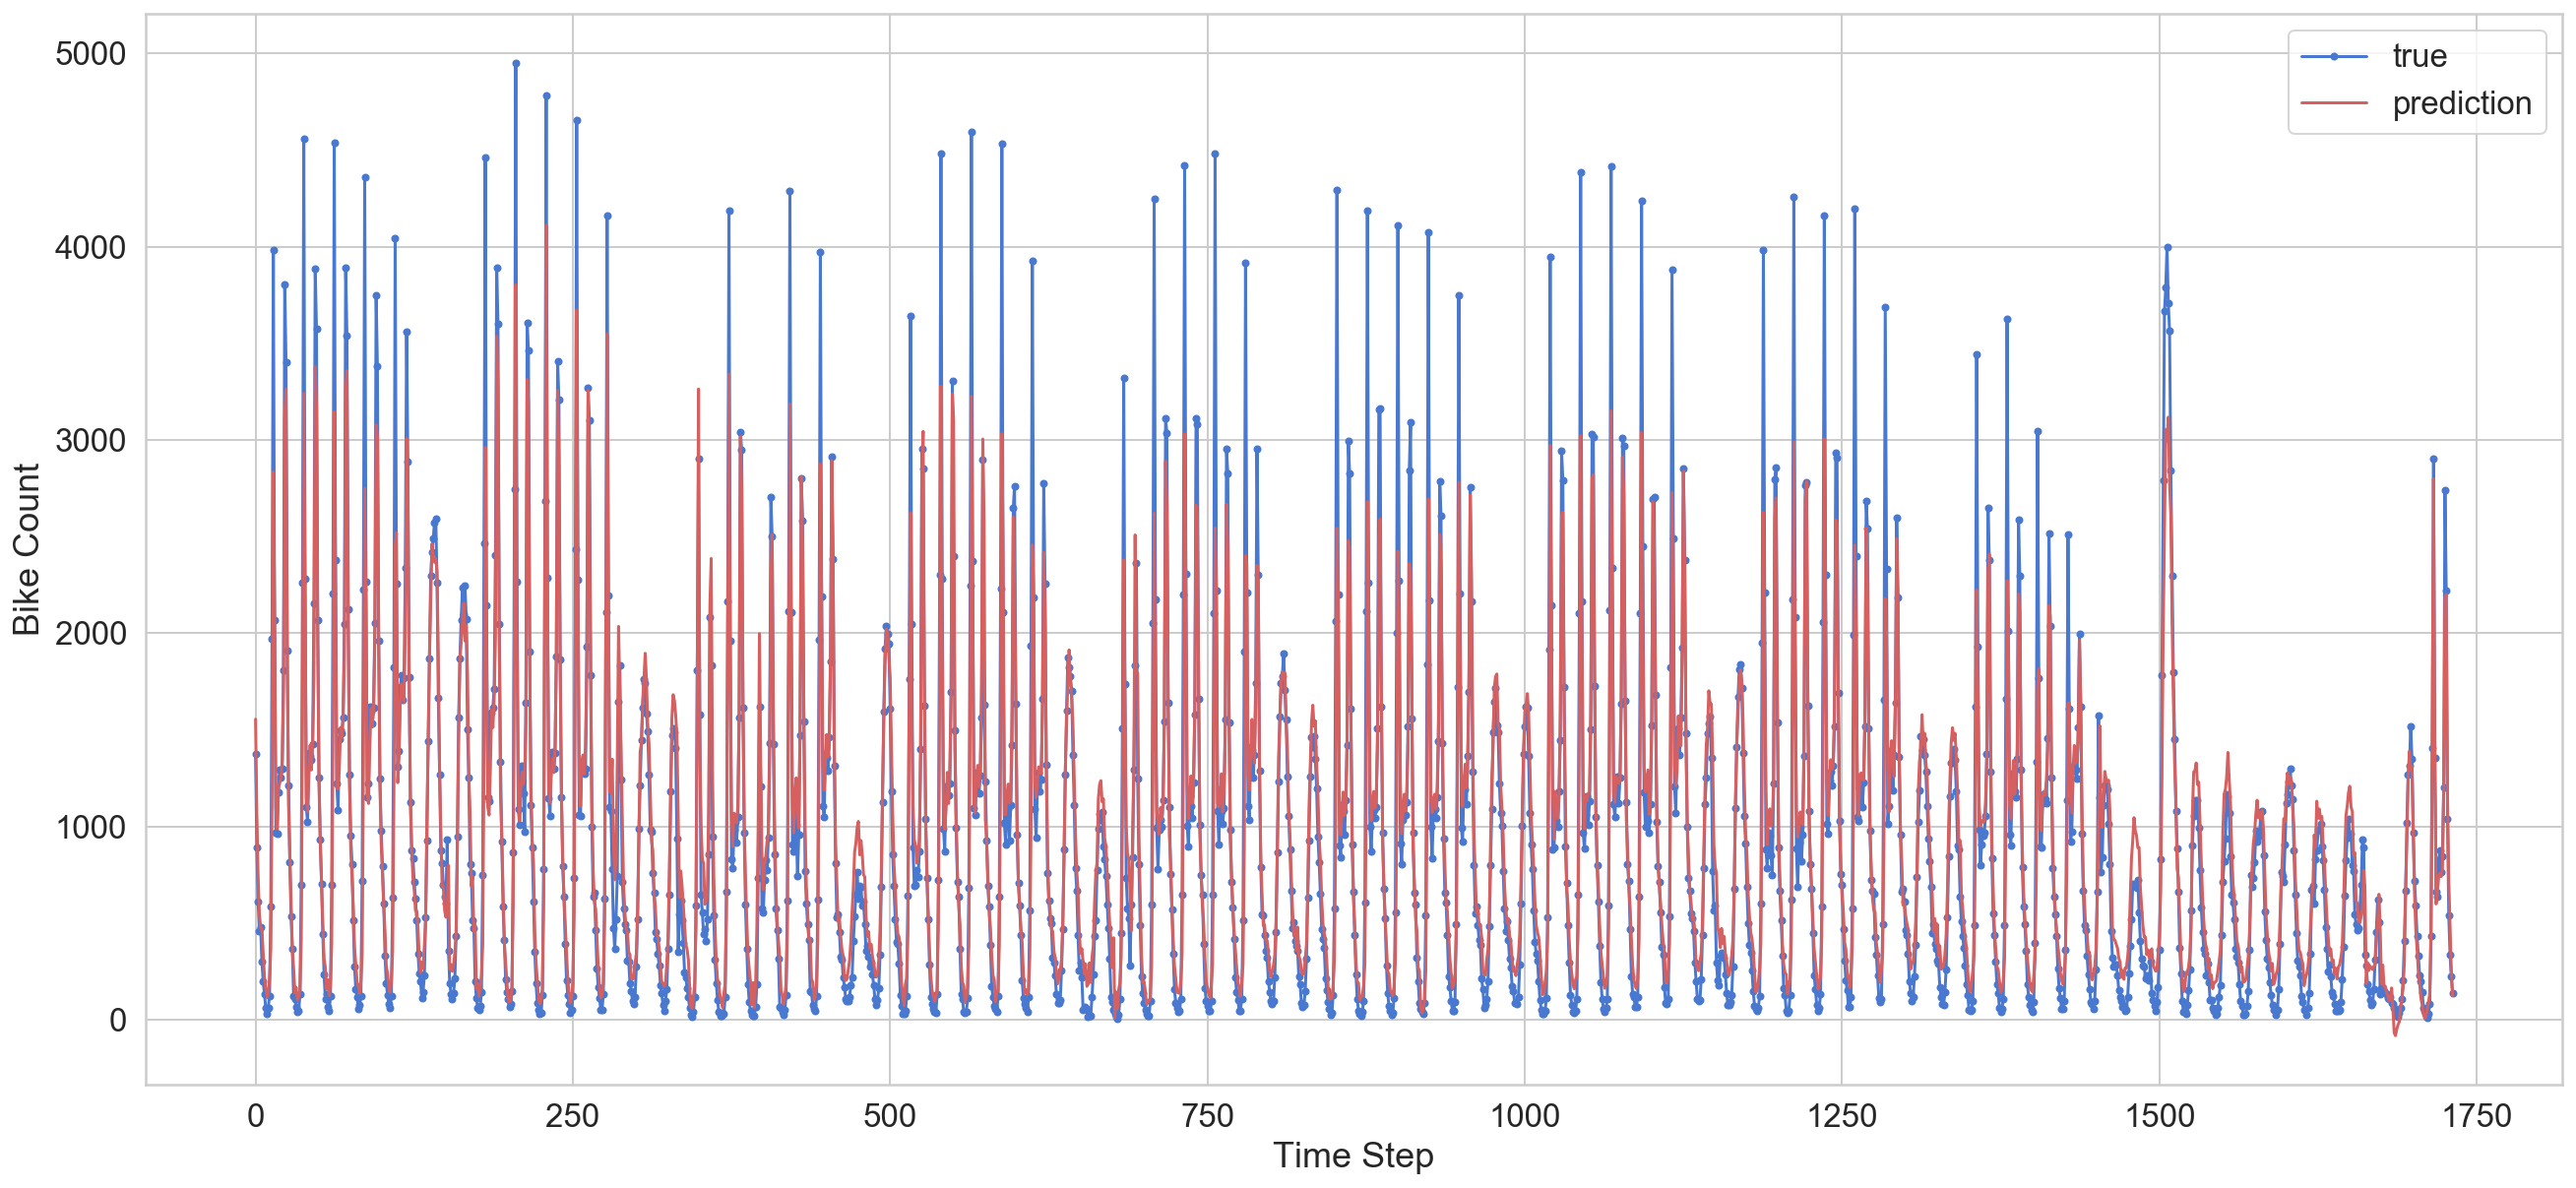

In [23]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

# 7- EVALUATING THE MODEL

Before any step , y_test and y_pred must be in same matrix size

In [65]:
y_test_inv.shape

(1732, 1)

In [66]:
y_pred_inv.shape

(1732, 1)

they are not the same size , we just resize one of them

In [67]:
y_test_inv.resize(1732,1)

In [74]:
y_test_inv.shape

(1732, 1)

In [75]:
y_pred_inv.shape

(1732, 1)

CALCULATE R^2 FOR TESTED DATA

In [76]:
from sklearn.metrics import r2_score
test_r2_score = r2_score(y_test_inv,y_pred_inv)
test_r2_score

0.9042208194992735

CALCULATE MSE FOR TESTED DATA

In [77]:
from sklearn.metrics import mean_squared_error
import math
test_MSE_score = math.sqrt(mean_squared_error(y_test_inv,y_pred_inv))

In [78]:
test_MSE_score

287.3090627403343